In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec
import itertools
from sklearn.naive_bayes import GaussianNB

In [2]:

# Ensure NLTK data is downloaded
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\georg\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:

# Load the datasets
news_df = pd.read_csv('./data/us_equities_news_dataset.csv')
stock_df = pd.read_csv('./data/NVDA.csv')

In [4]:
# Convert the date columns to datetime format for matching
news_df['Date'] = pd.to_datetime(news_df['release_date'])
stock_df['Date'] = pd.to_datetime(stock_df['Date'])

# Merge news data with stock prices based on publication date
merged_df = pd.merge(news_df, stock_df, on='Date', how='inner')

# Filter to keep only articles that have matching stock data
nvidia_df = merged_df[['content', 'Open', 'Close', 'Date']]

# Label the target variable based on the opening and closing prices
nvidia_df['target'] = np.where(nvidia_df['Open'] > nvidia_df['Close'], 0, 1)

# Display the first few rows to verify the merging and labeling
print("\nFiltered and Labeled Data:")
print(nvidia_df.head())
print(f"Number of documents: {nvidia_df.shape[0]}")


Filtered and Labeled Data:
                                             content     Open    Close  \
0  What s happening\nShares of Chinese electric c...  6.19475  6.13925   
1  Gainers  NIO  NYSE NIO   14   Village Farms In...  6.19475  6.13925   
2  Cemtrex  NASDAQ CETX   85  after FY results \n...  6.19475  6.13925   
3  aTyr Pharma  NASDAQ LIFE   63  on Kyorin Pharm...  5.80800  5.92650   
4  Gainers  NIO  NYSE NIO   14   Meritor  NYSE MT...  5.77250  5.88250   

        Date  target  
0 2020-01-15       0  
1 2020-01-15       0  
2 2020-01-15       0  
3 2020-01-06       1  
4 2019-12-31       1  
Number of documents: 197393


C:\Users\georg\AppData\Local\Temp\ipykernel_14984\152134549.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nvidia_df['target'] = np.where(nvidia_df['Open'] > nvidia_df['Close'], 0, 1)


In [5]:
# Check for duplicate documents based on the 'content' column
duplicate_docs = nvidia_df[nvidia_df['content'].duplicated(keep=False)]

# Display the duplicate documents (if any)
print(f"Number of duplicate documents found: {duplicate_docs.shape[0]}")
if not duplicate_docs.empty:
    print("Duplicate Documents:")
    print(duplicate_docs[['content']])

# Remove duplicate documents, keeping the first occurrence
nvidia_df = nvidia_df.drop_duplicates(subset='content', keep='first').reset_index(drop=True)

# Display the updated DataFrame
print(f"Number of documents after removing duplicates: {nvidia_df.shape[0]}")


Number of duplicate documents found: 769
Duplicate Documents:
                                                  content
309     Shares of Uber Technologies Inc  \r\n\r\n     ...
312     Shares of Uber Technologies Inc  \r\n\r\n     ...
625      Bloomberg     You can soon save for your next...
640      Bloomberg     You can soon save for your next...
1824    Sealed Air Corporation   NYSE SEE   delivered ...
...                                                   ...
194238  A physical bitcoin  BTC  is selling on eBay  N...
194239  A physical bitcoin  BTC  is selling on eBay  N...
196048  It s that time again   Mad Money  host Jim Cra...
196062  Evercore  In Line   40 target  notes that AT T...
196064  Evercore  In Line   40 target  notes that AT T...

[769 rows x 1 columns]
Number of documents after removing duplicates: 196919


In [6]:
# Basic descriptive statistics for the news dataset
num_articles = nvidia_df.shape[0]
average_words_per_article = nvidia_df['content'].apply(lambda x: len(str(x).split())).mean()
print(f'The number of articles before filtering is: {news_df.shape[0]}')
print(f"The number of articles after filtering is: {num_articles}")
print(f"The average amount of words per article is: {average_words_per_article}")



# Initialize the stemmer
stemmer = PorterStemmer()


# Tokenize content for word frequency analysis
nvidia_df.loc[:, 'text_length'] = nvidia_df['content'].apply(lambda x: len(str(x).split()))


# Tokenize content for word frequency analysis
nvidia_df.loc[:, 'processed_text'] = nvidia_df['content'].apply(lambda x: word_tokenize(str(x).lower()))


# Remove stopwords and punctuation for better NLP insights
stop_words = set(stopwords.words('english'))
# Remove stopwords, punctuation, and apply stemming
nvidia_df.loc[:, 'filtered_text'] = nvidia_df['processed_text'].apply(
    lambda words: [stemmer.stem(word) for word in words if word.isalpha() and word not in stop_words]
)


# Drop rows where the 'filtered_text' is empty (i.e., documents that became empty after preprocessing)
nvidia_df = nvidia_df.dropna(subset=['filtered_text']).reset_index(drop=True)

# Display how many articles remain after filtering
print(f"Number of articles after preprocessing: {nvidia_df.shape[0]}")

# Join the filtered words back into strings for TF-IDF
nvidia_df.loc[:, 'filtered_text_str'] = nvidia_df['filtered_text'].apply(lambda x: ' '.join(x))

nvidia_df = nvidia_df[nvidia_df['filtered_text_str'].str.strip() != '']

The number of articles before filtering is: 221513
The number of articles after filtering is: 196919
The average amount of words per article is: 579.355689395132
Number of articles after preprocessing: 196919


In [7]:
# TF-IDF Representation of Documents using the processed and filtered text
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)  # Reduced max features
tfidf_matrix = vectorizer.fit_transform(nvidia_df['filtered_text_str'])

In [8]:
# Prepare the text data for Word2Vec
sentences = nvidia_df['filtered_text'].tolist()

In [9]:
def document_embedding_tfidf(model, document, tfidf, feature_names, vector_size=100):
    """
    Compute a TF-IDF weighted document embedding by averaging the Word2Vec embeddings of words in the document.

    Parameters:
    - model: Trained Word2Vec model
    - document: List of tokenized words
    - tfidf: TfidfVectorizer object used for the document
    - feature_names: The list of features (terms) from the TF-IDF vectorizer
    - vector_size: Size of the word embeddings in the Word2Vec model

    Returns:
    - doc_embedding: The TF-IDF weighted document embedding as a numpy array
    """
    word_vectors = []
    weights = []

    # Extract the TF-IDF scores for the document
    tfidf_scores = tfidf.transform([" ".join(document)])
    tfidf_scores = tfidf_scores.toarray().flatten()

    feature_names = feature_names.tolist()  # Convert NumPy array to list

    for word in document:
        if word in model.wv.index_to_key and word in feature_names:
            # Get the word embedding
            word_vector = model.wv[word]
            word_index = feature_names.index(word)  # Get the index of the word in the TF-IDF feature list

            # Get the TF-IDF weight for this word
            tfidf_weight = tfidf_scores[word_index]

            # Collect the word vector and weight
            word_vectors.append(word_vector)
            weights.append(tfidf_weight)

    if len(word_vectors) == 0:
        # Return a zero vector if no words from the document are in the Word2Vec model
        return np.zeros(vector_size)

    # Convert lists to arrays
    word_vectors = np.array(word_vectors)
    weights = np.array(weights)

    # Compute the weighted average of word vectors
    doc_embedding = np.average(word_vectors, axis=0, weights=weights)

    return doc_embedding




In [10]:
# Define the grid of parameters to test
'''
vector_sizes = [100, 200, 300]
window_sizes = [3, 5, 7]
min_counts = [1, 5, 10]
sg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram
epochs = [10, 20]
'''

'\nvector_sizes = [100, 200, 300]\nwindow_sizes = [3, 5, 7]\nmin_counts = [1, 5, 10]\nsg_values = [0, 1]  # 0 for CBOW, 1 for Skip-gram\nepochs = [10, 20]\n'

In [11]:
# Dictionary to store best performance for each model configuration and classifier
best_performance = {
    'Word2Vec_with_negative_sampling_with_TFIDF': {
        'LogisticRegression': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None},
        'GaussianNB': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None}
    },
    'Word2Vec_with_negative_sampling_without_TFIDF': {
        'LogisticRegression': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None},
        'GaussianNB': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None}
    },
    'Word2Vec_without_negative_sampling_with_TFIDF': {
        'LogisticRegression': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None},
        'GaussianNB': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None}
    },
    'Word2Vec_without_negative_sampling_without_TFIDF': {
        'LogisticRegression': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None},
        'GaussianNB': {'best_f1_score': 0, 'best_accuracy': 0, 'best_params': None}
    }
}



# Function to update the best performance for a given configuration and classifier
def update_best_performance(model_type, classifier_type, f1, accuracy, params):
    if f1 > best_performance[model_type][classifier_type]['best_f1_score']:
        best_performance[model_type][classifier_type]['best_f1_score'] = f1
        best_performance[model_type][classifier_type]['best_accuracy'] = accuracy
        best_performance[model_type][classifier_type]['best_params'] = params



In [12]:
from sklearn.naive_bayes import GaussianNB

# Define the grid of parameters to test
vector_sizes = [200]
window_sizes = [5]
min_counts = [5]
sg_values = [1]  # 0 for CBOW, 1 for Skip-gram
epochs = [20]
negative_samples = [5]  # None means no negative sampling
use_tfidf = [True]  # For with/without TF-IDF

# Initialize TF-IDF vectorizer and compute feature names
tfidf_feature_names = vectorizer.get_feature_names_out()

# Iterate over all combinations of parameters including TF-IDF and negative sampling
for vector_size, window, min_count, sg, epoch, negative, use_tfidf_flag in itertools.product(vector_sizes, window_sizes, min_counts, sg_values, epochs, negative_samples, use_tfidf):
    
    # Model identifier for storing results
    model_type = f'Word2Vec_{"with" if negative else "without"}_negative_sampling_{"with_TFIDF" if use_tfidf_flag else "without_TFIDF"}'
    
    # Initialize Word2Vec with or without negative sampling
    if negative is not None:
        word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg, negative=negative)
    else:
        word2vec_model = Word2Vec(sentences, vector_size=vector_size, window=window, min_count=min_count, workers=4, sg=sg)
    
    # Train the model
    word2vec_model.train(sentences, total_examples=len(sentences), epochs=epoch)

    # Document embeddings, with or without TF-IDF
    if use_tfidf_flag:
        # Assuming TF-IDF embedding code here
        doc_embeddings = nvidia_df['filtered_text'].apply(
            lambda doc: document_embedding_tfidf(word2vec_model, doc, vectorizer, tfidf_feature_names, vector_size=vector_size)
        ).tolist()
    else:
        doc_embeddings = [np.mean([word2vec_model.wv[word] for word in sentence if word in word2vec_model.wv], axis=0) for sentence in sentences]

    # Check for empty embeddings
    X = np.array([embedding for embedding in doc_embeddings if embedding is not None and len(embedding) > 0])
    y = nvidia_df['target']

    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17, stratify=y)

    # ==========================
    # Train Logistic Regression
    # ==========================
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_train, y_train)

    # Get predictions on the test set
    y_pred = lr_model.predict(X_test)

    # Calculate accuracy and F1 score for Logistic Regression
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {model_type} - Logistic Regression, Vector Size: {vector_size}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Update best performance for Logistic Regression
    update_best_performance(model_type, 'LogisticRegression', f1, accuracy, (vector_size, window, min_count, sg, epoch, negative, use_tfidf_flag))

    # ==========================
    # Train Gaussian Naive Bayes
    # ==========================
    nb_model = GaussianNB()
    nb_model.fit(X_train, y_train)

    # Get predictions on the test set
    y_pred = nb_model.predict(X_test)

    # Calculate accuracy and F1 score for Naive Bayes
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Model: {model_type} - Gaussian Naive Bayes, Vector Size: {vector_size}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    
    # Update best performance for Naive Bayes
    update_best_performance(model_type, 'GaussianNB', f1, accuracy, (vector_size, window, min_count, sg, epoch, negative, use_tfidf_flag))

# After running all configurations, print the best performance for each model type and classifier
for model_type, classifiers in best_performance.items():
    for classifier_type, performance in classifiers.items():
        print(f"Best Performance for {model_type} - {classifier_type}:")
        print(f"F1 Score: {performance['best_f1_score']:.4f}, Accuracy: {performance['best_accuracy']:.4f}")
        print(f"Best Params: {performance['best_params']}")


Model: Word2Vec_with_negative_sampling_with_TFIDF - Logistic Regression, Vector Size: 200, Accuracy: 0.5280, F1 Score: 0.6581
Model: Word2Vec_with_negative_sampling_with_TFIDF - Gaussian Naive Bayes, Vector Size: 200, Accuracy: 0.5042, F1 Score: 0.4785
Best Performance for Word2Vec_with_negative_sampling_with_TFIDF - LogisticRegression:
F1 Score: 0.6581, Accuracy: 0.5280
Best Params: (200, 5, 5, 1, 20, 5, True)
Best Performance for Word2Vec_with_negative_sampling_with_TFIDF - GaussianNB:
F1 Score: 0.4785, Accuracy: 0.5042
Best Params: (200, 5, 5, 1, 20, 5, True)
Best Performance for Word2Vec_with_negative_sampling_without_TFIDF - LogisticRegression:
F1 Score: 0.0000, Accuracy: 0.0000
Best Params: None
Best Performance for Word2Vec_with_negative_sampling_without_TFIDF - GaussianNB:
F1 Score: 0.0000, Accuracy: 0.0000
Best Params: None
Best Performance for Word2Vec_without_negative_sampling_with_TFIDF - LogisticRegression:
F1 Score: 0.0000, Accuracy: 0.0000
Best Params: None
Best Performa

In [13]:
# After running all configurations, print the best performance for each model type and classifier
for model_type, classifiers in best_performance.items():
    for classifier_type, performance in classifiers.items():
        print(f"Best Performance for {model_type} - {classifier_type}:")
        print(f"F1 Score: {performance['best_f1_score']:.4f}, Accuracy: {performance['best_accuracy']:.4f}")
        print(f"Best Params: {performance['best_params']}")

Best Performance for Word2Vec_with_negative_sampling_with_TFIDF - LogisticRegression:
F1 Score: 0.6581, Accuracy: 0.5280
Best Params: (200, 5, 5, 1, 20, 5, True)
Best Performance for Word2Vec_with_negative_sampling_with_TFIDF - GaussianNB:
F1 Score: 0.4785, Accuracy: 0.5042
Best Params: (200, 5, 5, 1, 20, 5, True)
Best Performance for Word2Vec_with_negative_sampling_without_TFIDF - LogisticRegression:
F1 Score: 0.0000, Accuracy: 0.0000
Best Params: None
Best Performance for Word2Vec_with_negative_sampling_without_TFIDF - GaussianNB:
F1 Score: 0.0000, Accuracy: 0.0000
Best Params: None
Best Performance for Word2Vec_without_negative_sampling_with_TFIDF - LogisticRegression:
F1 Score: 0.0000, Accuracy: 0.0000
Best Params: None
Best Performance for Word2Vec_without_negative_sampling_with_TFIDF - GaussianNB:
F1 Score: 0.0000, Accuracy: 0.0000
Best Params: None
Best Performance for Word2Vec_without_negative_sampling_without_TFIDF - LogisticRegression:
F1 Score: 0.0000, Accuracy: 0.0000
Best 

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Step 1: Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

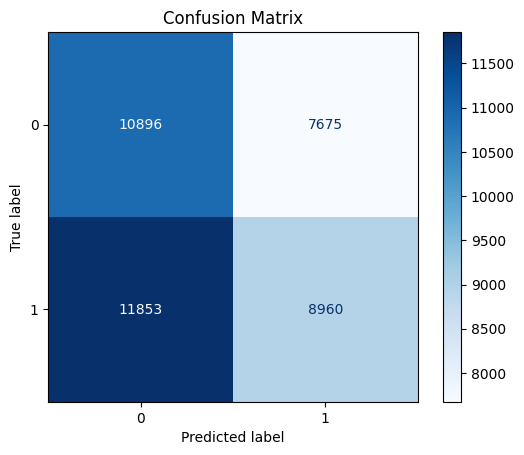

In [15]:

# Step 2: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)

plt.title('Confusion Matrix')
plt.show()